#Predicció de valors de la borsa d'una empresa fent servir una LSTM

Veurem com fer servir una Xarxa Neuronal Recurrent (de tipus LSTM) per a predir el valor de les accions de borsa d'una companyia. El que farem serà utilitzar dades històriques de preus d'accions per construir un model predictiu que pugui estimar els futurs moviments del preu de les accions.

In [ ]:
# Importa les biblioteques necessàries per a fer una LSTM
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import pandas as pd

##Llegim el dataset i l'explorem

Concretament, farem servir dades de la borsa de NASDAQ (*National Association of Securities Dealer Automated Quotation*), que és la borsa de valors electrònica més gran dels Estats Units.

In [ ]:
#Llegim el dataset, que el descarregarem fent servir la llibreria yfinance
import yfinance as yf

# Descarreguem les dades d'Amazon de NASDAQ
# Llegirem les dades des de l'any 2012 i fins a gener 2024
# Possibles empreses a consultar:
# Google: GOOGL
# Amazon: AMZN
# Apple: AAPL
# Netflix: NFLX
# Podeu consultar l'acrònim d'altres empreses a https://es.wikipedia.org/wiki/NASDAQ-100
empresa = 'AMZN'
dades = yf.download(empresa, start='2012-01-01', end='2024-01-01')

# Mostra les primeres files de les dades
print(dades.head())

[*********************100%%**********************]  1 of 1 completed

              Open    High     Low   Close  Adj Close     Volume
Date                                                            
2012-01-03  8.7945  8.9740  8.7775  8.9515     8.9515  102216000
2012-01-04  8.9605  9.0250  8.8035  8.8755     8.8755   84104000
2012-01-05  8.7970  8.9125  8.7025  8.8805     8.8805   76182000
2012-01-06  8.9035  9.2325  8.8750  9.1305     9.1305  140168000
2012-01-09  9.1380  9.2185  8.8500  8.9280     8.9280  101138000


Date
2012-01-03    8.7945
2012-01-04    8.9605
2012-01-05    8.7970
2012-01-06    8.9035
2012-01-09    9.1380
Name: Open, dtype: float64


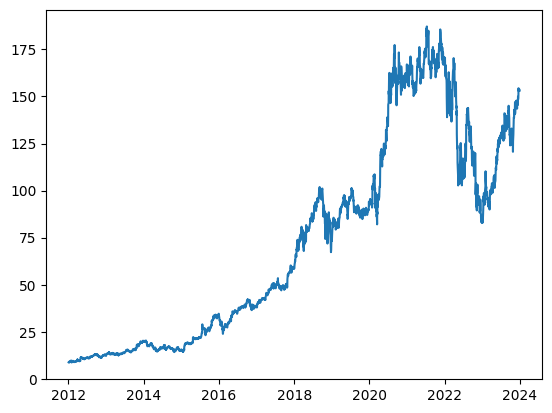

In [ ]:
#Ens quedem amb les dades d'Open i les visualitzem.
dades = dades['Open']
plt.plot(dades);
print(dades.head())

##Preprocessem les dades

In [ ]:
# Normalitzem les dades
scaler = MinMaxScaler()
dades_array = np.array(dades)
dades_escalades = scaler.fit_transform(dades_array.reshape(-1, 1))
print("Les dades més antigues:")
print(dades_escalades[0:5])
print("Les dades més recents:")
print(dades_escalades[-5::])

Les dades més antigues:
[[0.0005826 ]
 [0.00151252]
 [0.00059661]
 [0.00119321]
 [0.00250687]]
Les dades més recents:
[[0.81272709]
 [0.81155065]
 [0.81155065]
 [0.81244698]
 [0.8089738 ]]


In [ ]:
# Dividim les mostres en entrenament i test
mida_entrenament = int(len(dades_escalades)*0.8)
mida_test = len(dades_escalades) - mida_entrenament
dades_entrenament = dades_escalades[0:mida_entrenament,:]
dades_test = dades_escalades[mida_entrenament:len(dades_escalades),:1]

In [ ]:
# Creem petites series temporals per a entrenar i testejar
def crear_series_temporals(dades, longitud_serie):
    X, Y = [], []
    for i in range (0, len(dades) - longitud_serie-1):
      serie_X = dades[i:(i+longitud_serie)] # Seqüència de dades fins al moment actual
      serie_Y = dades[i+longitud_serie] # Valor següent a predir
      X.append(serie_X)
      Y.append(serie_Y)
    return np.array(X), np.array(Y)


longitud_serie = 10  # Longitud de la finestra de la sèrie temporal
X_train, y_train = crear_series_temporals(dades_entrenament, longitud_serie)
X_test, y_test = crear_series_temporals(dades_test, longitud_serie)
print("Les dades d'entrenament ténen la forma {}".format(X_train.shape))
print("Els valors a predir d'entrenament (y) ténen la forma {}".format(y_train.shape))
print("Les dades de test ténen la forma {}".format(X_test.shape))
print("Els valors a predir de test (y) ténen la forma {}".format(y_test.shape))

Les dades d'entrenament ténen la forma (2403, 10, 1)
Els valors a predir d'entrenament (y) ténen la forma (2403, 1)
Les dades de test ténen la forma (593, 10, 1)
Els valors a predir de test (y) ténen la forma (593, 1)


In [ ]:
# Eliminem la última dimensió:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0])

##Definim el model LSTM

In [ ]:
# Definim i compilem el model LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Entrena el model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

# Avalua el model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Pèrdua d\'entrenament:', train_loss)
print('Pèrdua de test:', test_loss)


Epoch 1/10
38/38 [==============================] - 3s 25ms/step - loss: 0.0788
Epoch 2/10
38/38 [==============================] - 1s 32ms/step - loss: 0.0020
Epoch 3/10
38/38 [==============================] - 1s 28ms/step - loss: 2.7488e-04
Epoch 4/10
38/38 [==============================] - 1s 16ms/step - loss: 2.0413e-04
Epoch 5/10
38/38 [==============================] - 1s 17ms/step - loss: 2.0068e-04
Epoch 6/10
38/38 [==============================] - 1s 26ms/step - loss: 1.8986e-04
Epoch 7/10
38/38 [==============================] - 1s 31ms/step - loss: 1.9152e-04
Epoch 8/10
38/38 [==============================] - 1s 34ms/step - loss: 1.8811e-04
Epoch 9/10
38/38 [==============================] - 1s 34ms/step - loss: 1.8281e-04
Epoch 10/10
38/38 [==============================] - 1s 16ms/step - loss: 1.8575e-04
Pèrdua d'entrenament: 0.00017553966608829796
Pèrdua de test: 0.0008527733152732253


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fem servir les dades per predir
prediccions_train = model.predict(X_train)
prediccions_test = model.predict(X_test)
# Desnormalitzem les prediccions
prediccions_train = scaler.inverse_transform(prediccions_train)
prediccions_test = scaler.inverse_transform(prediccions_test)
# Creem nous DataFrames amb l'índex original
prediccions_train = pd.DataFrame(prediccions_train, index=dades.index[:len(prediccions_train)])
prediccions_test = pd.DataFrame(prediccions_test, index=dades.index[len(dades)-len(prediccions_test):])


19/19 [==============================] - 0s 5ms/step


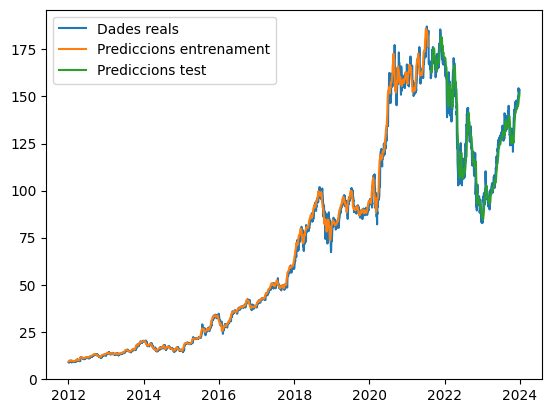

In [ ]:
# Gràfica de totes les prediccions
plt.plot(dades, label='Dades reals')
plt.plot(prediccions_train, label='Prediccions entrenament')
plt.plot(prediccions_test, label='Prediccions test')
plt.legend()
plt.show()

# Activitat

## Carregar dades

In [ ]:
#Llegim el dataset, que el descarregarem fent servir la llibreria yfinance
import yfinance as yf

# Descarreguem les dades d'Amazon de NASDAQ
# Llegirem les dades des de l'any 2012 i fins a gener 2024
# Possibles empreses a consultar:
# Google: GOOGL
# Amazon: AMZN
# Apple: AAPL
# Netflix: NFLX
# Podeu consultar l'acrònim d'altres empreses a https://es.wikipedia.org/wiki/NASDAQ-100
empresa = 'TEF'
dades = yf.download(empresa, start='2012-01-01', end='2024-01-01')

# Mostra les primeres files de les dades
print(dades.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2012-01-03  17.620001  17.889999  17.610001  17.730000   8.210289  3248000
2012-01-04  17.360001  17.420000  17.139999  17.330000   8.025058  2409200
2012-01-05  16.799999  16.950001  16.650000  16.860001   7.807415  3566300
2012-01-06  16.879999  16.879999  16.530001  16.580000   7.677753  3329500
2012-01-09  16.809999  16.820000  16.530001  16.690001   7.728692  2415500


Date
2012-01-03    17.620001
2012-01-04    17.360001
2012-01-05    16.799999
2012-01-06    16.879999
2012-01-09    16.809999
Name: Open, dtype: float64


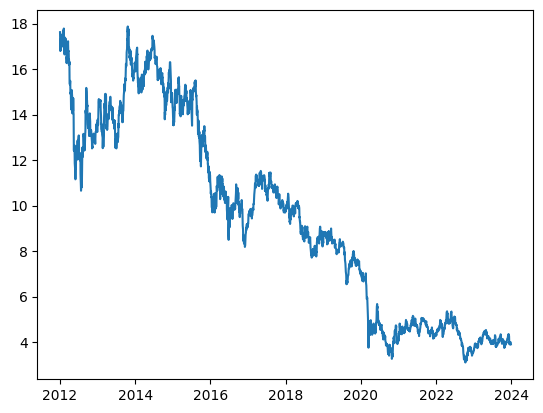

In [ ]:
#Ens quedem amb les dades d'Open i les visualitzem.
dades = dades['Open']
plt.plot(dades);
print(dades.head())

## Preparar dades per entrenar amb les noves capes

In [ ]:
# Normalitzem les dades
scaler = MinMaxScaler()
dades_array = np.array(dades)
dades_escalades = scaler.fit_transform(dades_array.reshape(-1, 1))
print("Les dades més antigues:")
print(dades_escalades[0:5])
print("Les dades més recents:")
print(dades_escalades[-5::])

Les dades més antigues:
[[0.9830738 ]
 [0.96547054]
 [0.92755575]
 [0.93297213]
 [0.92823282]]
Les dades més recents:
[[0.05890319]
 [0.06025728]
 [0.05754909]
 [0.0548409 ]
 [0.05416386]]


In [ ]:
# Dividim les mostres en entrenament i test
mida_entrenament = int(len(dades_escalades)*0.8)
mida_test = len(dades_escalades) - mida_entrenament
dades_entrenament = dades_escalades[0:mida_entrenament,:]
dades_test = dades_escalades[mida_entrenament:len(dades_escalades),:1]

In [ ]:
# Creem petites series temporals per a entrenar i testejar
def crear_series_temporals(dades, longitud_serie):
    X, Y = [], []
    for i in range (0, len(dades) - longitud_serie-1):
      serie_X = dades[i:(i+longitud_serie)] # Seqüència de dades fins al moment actual
      serie_Y = dades[i+longitud_serie] # Valor següent a predir
      X.append(serie_X)
      Y.append(serie_Y)
    return np.array(X), np.array(Y)


longitud_serie = 10  # Longitud de la finestra de la sèrie temporal
TX_train, ty_train = crear_series_temporals(dades_entrenament, longitud_serie)
TX_test, ty_test = crear_series_temporals(dades_test, longitud_serie)
print("Les dades d'entrenament ténen la forma {}".format(TX_train.shape))
print("Els valors a predir d'entrenament (y) ténen la forma {}".format(ty_train.shape))
print("Les dades de test ténen la forma {}".format(TX_test.shape))
print("Els valors a predir de test (y) ténen la forma {}".format(ty_test.shape))

Les dades d'entrenament ténen la forma (2403, 10, 1)
Els valors a predir d'entrenament (y) ténen la forma (2403, 1)
Les dades de test ténen la forma (593, 10, 1)
Els valors a predir de test (y) ténen la forma (593, 1)


In [ ]:
# Eliminem la última dimensió:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0])

## Reutilitzar el model anterior congelant les primeres capes

In [ ]:
from keras.layers import Flatten
from keras.models import Model

In [ ]:
# Congelar les capes primeres excepte l'última
tf_model = model
for layer in tf_model.layers[:-1]:
  layer.trainable = False

In [ ]:
# elimina l'ultima capa
# tf_model.layers.pop()

In [ ]:
# afegim noves capes
# tf_model.add(Dense(10, activation='softmax'))
# tf_model.add(Dense(1,activation='relu'))

In [ ]:
print("Number of weights after calling the model:", len(tf_model.weights))
tf_model.summary()

Number of weights after calling the model: 5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 10400 (40.62 KB)
_________________________________________________________________


## Compilar i entrenar model nou

In [ ]:
tf_model.compile(optimizer='adam', loss='mse')

In [ ]:
tf_model.fit(TX_train, ty_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
38/38 [==============================] - 2s 11ms/step - loss: 4.5284e-04
Epoch 2/10
38/38 [==============================] - 0s 10ms/step - loss: 4.4189e-04
Epoch 3/10
38/38 [==============================] - 0s 10ms/step - loss: 4.3787e-04
Epoch 4/10
38/38 [==============================] - 0s 12ms/step - loss: 4.3889e-04
Epoch 5/10
38/38 [==============================] - 0s 12ms/step - loss: 4.3581e-04
Epoch 6/10
38/38 [==============================] - 1s 16ms/step - loss: 4.3667e-04
Epoch 7/10
38/38 [==============================] - 1s 13ms/step - loss: 4.2365e-04
Epoch 8/10
38/38 [==============================] - 0s 11ms/step - loss: 4.1938e-04
Epoch 9/10
38/38 [==============================] - 0s 10ms/step - loss: 4.1869e-04
Epoch 10/10
38/38 [==============================] - 0s 10ms/step - loss: 4.1885e-04


## Executar el model entrenat amb les dades de telefonica

In [ ]:
# Fem servir les dades per predir
prediccions_train = tf_model.predict(TX_train)
prediccions_test = tf_model.predict(TX_test)
# Desnormalitzem les prediccions
prediccions_train = scaler.inverse_transform(prediccions_train)
prediccions_test = scaler.inverse_transform(prediccions_test)
# Creem nous DataFrames amb l'índex original
prediccions_train = pd.DataFrame(prediccions_train, index=dades.index[:len(prediccions_train)])
prediccions_test = pd.DataFrame(prediccions_test, index=dades.index[len(dades)-len(prediccions_test):])

19/19 [==============================] - 0s 4ms/step


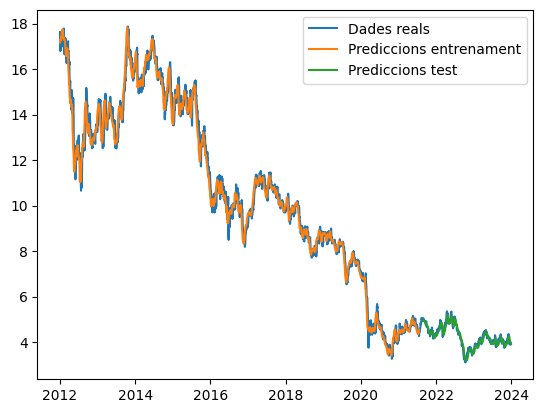

In [ ]:
# Gràfica de totes les prediccions
plt.plot(dades, label='Dades reals')
plt.plot(prediccions_train, label='Prediccions entrenament')
plt.plot(prediccions_test, label='Prediccions test')
plt.legend()
plt.show()

# Conclusió

Com podem observar, s'han congelat les primeres capes y s'ha fet entrenat l'última capa amb el nou set de variables. Com podem observar, l'alineament entre les dades predites i les esperades es bastant precís.

Per carregar els pesos del model s'hagués pogut fer amb model.load_weights(...), també s'hagués pogut guardar el model i carregar-ho. Per simplificar el procés he decidit el mes práctic ja que l'execució de tot plegat es bastant ràpid.

Documentació sobre sequential model consultada:
https://www.tensorflow.org/guide/keras/sequential_model